In [1]:
import os
import json
import gzip
import random
import pandas as pd
import seaborn as sns
from urllib.request import urlopen

In [2]:
GZIP_PATH = "Video_Games.json.gz"

In [3]:
data = []
with gzip.open(GZIP_PATH) as f:
    data.extend(json.loads(l.strip()) for l in f)
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

2565349
{'overall': 1.0, 'verified': True, 'reviewTime': '06 9, 2014', 'reviewerID': 'A21ROB4YDOZA5P', 'asin': '0439381673', 'reviewerName': 'Mary M. Clark', 'reviewText': 'I used to play this game years ago and loved it. I found this did not work on my computer even though it said it would work with Windows 7.', 'summary': 'Did not like this', 'unixReviewTime': 1402272000}


In [4]:
from collections import Counter
import json

In [5]:
#Number of unique items
counts = Counter([item['asin'] for item in data])
len(counts)

71982

In [6]:
#Sort by date
sorted_data = sorted(data, key=lambda x: x['unixReviewTime'])

In [7]:
sorted_data[-1]

{'overall': 1.0,
 'verified': True,
 'reviewTime': '10 2, 2018',
 'reviewerID': 'AXBO2KGK2B4UP',
 'asin': 'B01HD1B64C',
 'style': {'Platform:': ' PlayStation 4'},
 'reviewerName': 'Kevin',
 'reviewText': 'This game is garbage. Choppy controls, mediocre graphics, dull gameplay, and easily one of the hammiest and most poorly written intro videos in modern gaming, this game simply does nothing right.',
 'summary': 'Avoid this game',
 'unixReviewTime': 1538438400}

In [8]:
#Only get reviews starting from 2010
# filtered_data = filter(lambda x: x['unixReviewTime'] >= 1262314861, data)
# filtered_data = list(filtered_data)
filtered_data = sorted_data

In [9]:
data = sorted(filtered_data, key=lambda x: x['unixReviewTime'])
len(data)

2565349

In [10]:
#Remove unwanted fields

for entry in data:
    if 'reviewTime' in entry:
        del entry['reviewTime']
    if 'style' in entry:
        del entry['style']
    if 'reviewerName' in entry:
        del entry['reviewerName']
    if 'reviewText' in entry:
        del entry['reviewText']
    if 'summary' in entry:
        del entry['summary']
    if 'image' in entry:
        del entry['image']

In [11]:
df = pd.DataFrame.from_dict(data)
df.head()

,overall,verified,reviewerID,asin,unixReviewTime,vote
0,5.0,False,AR9HFLYSXUOYS,B00000JL6V,878947200,NaN
1,5.0,False,A26Y5BK10TL1OI,B00000JL6V,880761600,NaN
2,5.0,False,A3VMPX6KW6VSQY,B00000JL6V,881884800,NaN
3,1.0,False,A3N83WBSOG9PE4,B00000JL6V,882057600,2
4,4.0,False,A2Q6FRINMH0R81,B00000JL6V,882230400,NaN


In [12]:
#Fill vote NaN to 0
df[['vote']] = df[['vote']].fillna(value=0)
df.head()

,overall,verified,reviewerID,asin,unixReviewTime,vote
0,5.0,False,AR9HFLYSXUOYS,B00000JL6V,878947200,0
1,5.0,False,A26Y5BK10TL1OI,B00000JL6V,880761600,0
2,5.0,False,A3VMPX6KW6VSQY,B00000JL6V,881884800,0
3,1.0,False,A3N83WBSOG9PE4,B00000JL6V,882057600,2
4,4.0,False,A2Q6FRINMH0R81,B00000JL6V,882230400,0


In [13]:
#Number of reviews per product
df.groupby(['asin']).count()['overall']

asin
0042000742     1
0078764343     4
0276425316     1
0324411812     1
0439335299     1
              ..
B01HJ14OT0     1
B01HJ14TTA     4
B01HJ1521Y     1
B01HJC33WS    22
B01HJEBIAA    30
Name: overall, Length: 71982, dtype: int64

In [ ]:
overall_count = pd.DataFrame(df['overall'].value_counts()).reset_index()
overall_count.columns = ['overall', 'count']
overall_count

: 

: 

In [14]:
#Get popular products -- Products that have more than 1k reviews
popular_data = df.groupby("asin").filter(lambda x:x['overall'].count() >= 1000)
popular_products = pd.DataFrame(popular_data.groupby('asin')['overall'].count())
popular_products = popular_products.sort_values('overall', ascending=False)

Text(0.5, 1.0, 'Popular Products Bar Chart')

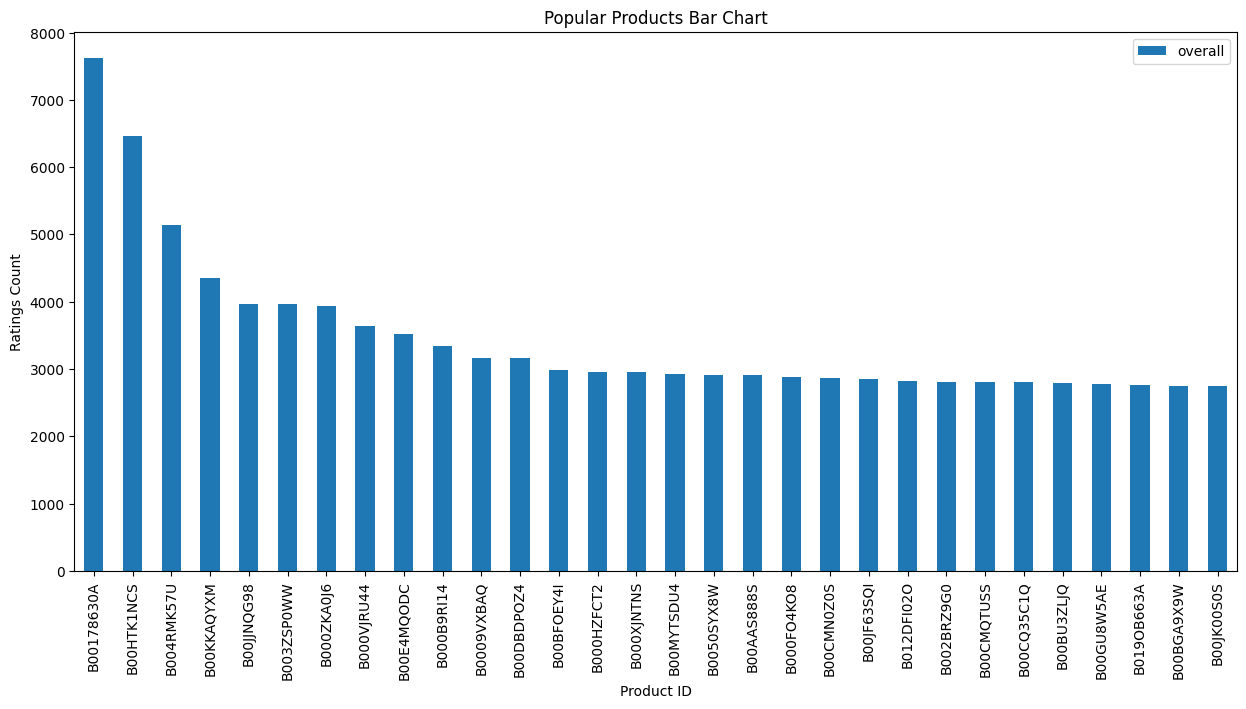

In [15]:
ax = popular_products.head(30).plot(kind = "bar", figsize=(15,7))
ax.set_xlabel("Product ID")
ax.set_ylabel("Ratings Count")
ax.set_title("Popular Products Bar Chart")

In [16]:
# from surprise import KNNWithMeans
from surprise import SVD, SVDpp, NMF, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise.model_selection import GridSearchCV

In [17]:
cf_data = df[['reviewerID', 'asin', 'overall']]
cf_data.head()

,reviewerID,asin,overall
0,AR9HFLYSXUOYS,B00000JL6V,5.0
1,A26Y5BK10TL1OI,B00000JL6V,5.0
2,A3VMPX6KW6VSQY,B00000JL6V,5.0
3,A3N83WBSOG9PE4,B00000JL6V,1.0
4,A2Q6FRINMH0R81,B00000JL6V,4.0


In [18]:
reader = Reader(rating_scale=(1, 5))

full_data = Dataset.load_from_df(cf_data, reader)
traindata = full_data.build_full_trainset()

In [19]:
#Build anti test set

fill = traindata.global_mean

anti_testset = []
for u in traindata.all_users()[0:1]:
    user_items = {j for (j, _) in traindata.ur[u]}

    anti_testset += [
        (traindata.to_raw_uid(u), traindata.to_raw_iid(i), fill) for i in traindata.all_items() if i not in user_items ]

In [20]:
algo = SVD()
algo.fit(traindata)

In [21]:
predictions = algo.test(anti_testset)

In [22]:
# return number of items rated by given user
def get_Iu(uid):
    try:
        return len(traindata.ur[traindata.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
# return number of users that have rated given item
def get_Ui(iid):
    try: 
        return len(traindata.ir[traindata.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [23]:
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
69089,AR9HFLYSXUOYS,B01FSYP04I,4.022095,4.022086,{'was_impossible': False},1,3,0.000009
22995,AR9HFLYSXUOYS,B000035XOZ,4.022095,4.022083,{'was_impossible': False},1,2,0.000012
16188,AR9HFLYSXUOYS,B000SQ5LNW,4.022095,4.022130,{'was_impossible': False},1,8,0.000035
40659,AR9HFLYSXUOYS,B00HAZ6BVA,4.022095,4.022055,{'was_impossible': False},1,6,0.000040
45789,AR9HFLYSXUOYS,B00E8IBYFK,4.022095,4.022140,{'was_impossible': False},1,1,0.000045
70440,AR9HFLYSXUOYS,B012J285C6,4.022095,4.022045,{'was_impossible': False},1,2,0.000049
331,AR9HFLYSXUOYS,B00001IVWH,4.022095,4.022148,{'was_impossible': False},1,4,0.000053
36348,AR9HFLYSXUOYS,B00BG2LKLO,4.022095,4.022149,{'was_impossible': False},1,1,0.000054
30077,AR9HFLYSXUOYS,B0050SVHZO,4.022095,4.022040,{'was_impossible': False},1,287,0.000054
71473,AR9HFLYSXUOYS,B01CG8TT64,4.022095,4.022151,{'was_impossible': False},1,1,0.000056


In [24]:
worst_predictions = df.sort_values(by='err')[-10:]
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
49943,AR9HFLYSXUOYS,B00TDGD1WG,4.022095,1.787658,{'was_impossible': False},1,50,2.234437
55219,AR9HFLYSXUOYS,B00ZTO4OF4,4.022095,1.752149,{'was_impossible': False},1,41,2.269946
63446,AR9HFLYSXUOYS,B01CREKLC8,4.022095,1.750386,{'was_impossible': False},1,187,2.271709
31351,AR9HFLYSXUOYS,B008VFUQX2,4.022095,1.727051,{'was_impossible': False},1,23,2.295044
21026,AR9HFLYSXUOYS,B002CMU7V6,4.022095,1.707631,{'was_impossible': False},1,95,2.314464
51744,AR9HFLYSXUOYS,B00W1YX2XK,4.022095,1.704280,{'was_impossible': False},1,70,2.317815
23014,AR9HFLYSXUOYS,B00452VGZW,4.022095,1.487306,{'was_impossible': False},1,354,2.534789
66275,AR9HFLYSXUOYS,B01EGHIB58,4.022095,1.463742,{'was_impossible': False},1,41,2.558353
65024,AR9HFLYSXUOYS,B00ZQD7VNK,4.022095,1.431929,{'was_impossible': False},1,369,2.590166
43930,AR9HFLYSXUOYS,B00LPBD2WG,4.022095,1.408070,{'was_impossible': False},1,37,2.614025


In [25]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.3678


0.36781403083068237

In [26]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

for uid, user_ratings in top_n.items():
    print("User ID:", uid, "Recommended items:", [iid for (iid, _) in user_ratings])

User ID: AR9HFLYSXUOYS Recommended items: ['B00005MNRY', 'B00104UBY0', 'B00136MBHA', 'B0015HZLVA', 'B001CXYMFS', 'B002BRZ9G0', 'B002UVG722', 'B000B6OR4I', 'B005C1B3C6', 'B0094X2066']


In [27]:
METADATA_JSON_PATH = "VideoGames_meta.json"

with open(METADATA_JSON_PATH) as f:
    meta_json = json.load(f)


df_meta = pd.json_normalize(meta_json)

In [29]:
df_meta[['asin']]

,asin
0,0042000742
1,0078764343
2,0276425316
3,0324411812
4,0439335310
...,...
84814,B01HJ1521Y
84815,B01HJ14TTA
84816,B01HJ14OT0
84817,B01HJC33WS


In [28]:
recommendations = {uid: [iid for (iid, _) in user_ratings] for uid, user_ratings in top_n.items()}

In [30]:
def get_item(asin):
    return df_meta[df_meta['asin'].str.contains(asin)]

def get_recommendations(uid):
    items_id = recommendations[uid]
    return [get_item(item).head(1)['title'].iloc[0] for item in items_id]

In [31]:
random_user = random.choice(list(recommendations.keys()))

print("Random user:",random_user)
print("Recommendations")
get_recommendations(random_user)

Random user: AR9HFLYSXUOYS
Recommendations


['Panzer Front',
 'Mamas &amp; Papas Soft Toy, Peanut Elephant',
 'The World Ends With You',
 ' Tales of Vesperia - Xbox 360',
 'Thrustmaster T-Flight Hotas X Flight Stick',
 'New Super Mario Bros. Wii',
 'New Super Mario Bros. Wii',
 'Cyclops CYC-80RH 1 LED Utility Bore Light, Black',
 '3C PRO 16GB 16G Class 10 C10 microSD microSDHC SDHC Extreme Speed Memory Card with SD Adapter and R13 Micro USB Flash Card Reader / Writer',
 'Nintendo Nunchuk Controller - White']